# Modules

In [100]:
import missingno  as msno
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Get data

In [2]:
import json
import pandas as pd
from sodapy import Socrata
from datetime import datetime,timedelta


class Get_Data():
    def __init__(self, df= pd.DataFrame()):
        self.df= df
    
    def create_df(self):
        
        client = Socrata("data.lacity.org", None)
        results = client.get("2nrs-mtv8", limit=800000)
        results_df = pd.DataFrame.from_records(results)
        results_df.to_csv(r'lapd.csv')
        self.df = results_df
    
    
    def create_df_n_days(self,n):
        client = Socrata("data.lacity.org", None)
        # filtro para traer los ultimos n días
        date_filter = (datetime.utcnow() - timedelta(days=n)).strftime("%Y-%m-%dT%H:%M:%S.%f")
        results = client.get("2nrs-mtv8", where=f"date_rptd >= '{date_filter}'", limit=800000)
        results_df = pd.DataFrame.from_records(results)
        results_df.to_csv(r'lapd_'+str(n)+'_days.csv')
        self.df = results_df       

        
    def infer_dtypes(self):
        ls_dates=["date_rptd", "date_occ"]
        ls_numeric=["vict_age","lat", "lon"]
        ls_strings=[x for x in self.df.columns if x not in ls_dates+ls_numeric]
        for date in ls_dates:
            self.df[date]= pd.to_datetime(self.df[date])
        for num in ls_numeric:
            self.df[num]= pd.to_numeric(self.df[num])
        for s in ls_strings:
            self.df[s].apply(lambda x: str(x).split(','))
        self.df["time_occ"]=self.df["time_occ"].apply(lambda x: int(x[0:2])*60+int(x[2:]))

In [3]:
data_loader= Get_Data()

In [7]:
data_loader.create_df_n_days(70)

In [8]:
data_loader.infer_dtypes()

In [9]:
data=data_loader.df

## Cleaner

In [69]:
from pandas import DataFrame, read_excel, read_csv
from numpy import nan
import csv
import pickle


class ProductionCleaner():

    def __init__(self,data):
        self.df=data.copy()

        
    def manageNan(self):
        # fill nan's and typos
        #self.df.loc[self.df.vict_age==0,'vict_age']=nan
        #self.df.loc[(self.df.vict_age<0)|(self.df.vict_age>100),'vict_age']=nan
        self.df['weapon_used_cd'].fillna('0',inplace=True)
        #self.df["premis_cd"].fillna('746',inplace=True)
        self.df.loc[self.df.vict_sex.isna(),'vict_sex']='X'
        self.df.loc[self.df.vict_sex=='H','vict_sex']=='X'
        self.df.loc[self.df.vict_descent.isna(),'vict_descent']='U'
        self.df.loc[self.df.lon==0,['lat','lon']]=nan
    
    def dropColumns(self):
        # Drop columns
        self.df.drop(['crm_cd_1','crm_cd_2','crm_cd_3','crm_cd_4','area_name','time_occ',
                      'crm_cd_desc','premis_desc','weapon_desc', 'status_desc','area_name',
                      'date_occ','area','rpt_dist_no','part_1_2','mocodes', "vict_age"],axis=1,inplace=True)
        try:
            self.df.drop(self.df.loc[self.df.status=='CC'].index,inplace=True)
        except:
            pass
        
    def manageLocation(self):
        # Delete spaces
        self.df.location = self.df.location.str.strip()
        self.df.location = self.df.location.apply(lambda x: "  ".join(x.split()))
        self.df.location = self.df.location.str.replace(" ", "")
        self.df.location = self.df.location.str.upper()
        # Replace with dictonary values
        directorio = read_csv('Data/Cleaner/Directorio_Lat_Lon.csv')
        directorio.location = directorio.location.str.replace(" ", "")
        directorio.location = directorio.location.str.upper()
        loc_lat = dict(zip(directorio.location,directorio.lat))
        loc_lon = dict(zip(directorio.location,directorio.lon))
    
        # Verificar si las columnas "lat" o "lon" tienen valores faltantes
        mask = self.df['lat'].isna() | self.df['lon'].isna()
        # Verificar si los valores de la columna "location" están en las claves del diccionario "loc_lat"
        not_found = ~self.df.loc[mask, 'location'].isin(loc_lat.keys())
        self.df.loc[mask & ~not_found, 'lat'] = self.df.loc[mask & ~not_found, 'location'].map(loc_lat)
        self.df.loc[mask & ~not_found, 'lon'] = self.df.loc[mask & ~not_found, 'location'].map(loc_lon)
        ## Aqui duda, borramos los que no estan en el diccionario y son nulos o que sugieren?
        self.df.drop('location',axis=1,inplace=True)
        
    def clean(self):
        ## Esta funcion ya nos deja los datos sin nulos
        self.df.drop('cross_street',axis=1,inplace=True)
        self.manageNan()
        self.dropColumns()
        print(self.df.columns)
        self.manageLocation()
        
    
            
    def clipping(self):
        self.df['lon']=self.df['lon'].clip(-118.7, -118.1)
        self.df['lat']=self.df['lat'].clip(33.6, 34.4)
        
    def lugar(self):
        pl=[[[119,120,121,145,146.0,150.0,501.0, 502.0, 504.0,507.0, 508.0, 509.0, 510.0,511,515.0, 516.0,707],['vivienda']],
            [[101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 109.0, 110.0,116,117,
              124.0, 125.0,128,136.0, 137.0,152,154,158,415,705.0,748.0],['calle']],
            [[725.0, 726.0,240.0,732.0,752,753,756.0],['gobierno']],
            [[123,142,156,204.0, 213.0],['estacionamiento']],
            [[151.0,157.0,238,241,254,302,303,304.0, 305.0,702],['establecimiento']],
            [[201.0, 202.0, 203.0,205.0, 206.0,208,209.0, 210.0, 211.0,217.0, 218.0,
                                219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0,228,233.0,242,244.0, 245.0,
                                247.0, 248.0, 249.0,250.0, 251.0, 252.0,255,401.0, 402.0, 404.0, 405.0,
                                406.0, 407.0, 408.0,409.0, 410.0, 411.0, 412.0, 413.0, 414.0,417.0,703,
                                148.0,709,301,216
                                ],['establecimiento_publico']],
            [[207,706.0,733.0,735.0],['nocturno']],
            [[503,505,519.0],['hotel']],
            [[111.0, 112.0, 113.0, 114.0, 115.0,122,126,212.0, 214.0, 215.0,801.0, 802.0,804,809.0, 810.0,
                 811.0, 834.0, 835.0, 836.0, 868.0, 869.0, 870.0, 871.0, 872.0, 873.0,
                 874.0, 875.0, 876.0, 877.0, 878.0, 879.0, 880.0, 882.0, 883.0, 884.0,
                                885.0, 889.0, 890.0, 891.0, 892.0, 893.0, 894.0, 895.0, 896.0, 897.0,
                                898.0, 900.0, 901.0, 902.0, 903.0, 904.0, 905.0, 906.0, 907.0, 908.0,
                                909.0, 910.0, 911.0, 912.0, 913.0, 915.0, 916.0, 917.0, 918.0, 919.0,
                                920.0, 921.0, 922.0, 931.0, 932.0, 933.0, 934.0, 935.0, 936.0, 937.0,
                                940.0, 941.0, 942.0, 943.0, 944.0, 945.0, 946.0, 947.0, 948.0, 949.0,
                                950.0, 951.0, 952.0, 953.0, 954.0, 956.0, 957.0, 958.0, 961.0, 962.0,
                                963.0, 964.0, 965.0, 966.0, 967.0, 968.0, 969.0, 970.0, 971.0,129,135
                               ],['transporte']],
            [[138,143,727,140],['escaleras']],
            [[139,108,147.0,712.0,713,144,714.0, 715.0, 716.0, 717.0, 718.0,711,734.0, 736.0, 737.0, 738.0, 739.0,
                  742.0, 743.0,754,757.0, 758.0],['recreacion']],
            [[141,149,155,745.0,107.0,118,506.0,518.0,127],['espacio_abierto']],
            [[227.0,234.0, 235.0, 236.0, 237.0,239,246.0,253,403,701.0,719,755],['medico']],
            [[229,601,602.0, 603.0, 604.0, 605.0, 606.0, 607.0, 608.0],['financiero']],
            [[230.0, 512.0,514,517],['cuidado_personas']],
            [[231.0,704.0,720.0, 721.0, 722.0, 723.0,724.0,729],['escuela']],
            [[232.0,245.0,513,710,744.0,746.0],['otro']],
            [[709.0, 730.0, 731.0,740],['iglesia']],
            [[750.0, 751.0],['internet']]]
        premis=[]
        for secc in pl:
            premis+=list(zip(secc[0],secc[1]*len(secc[0])))
        premis=dict(premis)
        self.df.premis_cd= self.df.premis_cd.astype("float")
        self.df['premis']=self.df["premis_cd"].apply(lambda x: premis[x] if x in premis.keys() else "otro")
    def zonas(self):
        clusters=pickle.load(open('models/Cleaner/cluster5.sav','rb'))
        self.df['zonas']=clusters.predict(self.df[['lat','lon']])
    def categorias(self):
        columnas=['weapon_used_cd','premis']
        for col in columnas:
            with open("Data/Cleaner/"+col+"_categorias", "rb") as fp:  
                lista = pickle.load(fp)
            self.df[col]=self.df[col].apply(lambda x: x if x in lista else 'Others')
    def simple_imp(self):
        with open("Data/Cleaner/imputer_mode", "rb") as fp:
            imputador= pickle.load(fp)
        self.df[['premis_cd','crm_cd','status']]=imputador.transform(self.df[['premis_cd','crm_cd','status']])
    def super_clases(self):
        temp=read_csv('Data/Cleaner/crcode_Supclass.csv')
        #temp.drop('NewCode',axis=1,inplace=True)
        self.df.crm_cd= self.df.crm_cd.astype("int")
        self.df=self.df.merge(temp, how='left', left_on='crm_cd', right_on='crm_cd')
        self.df.drop('crm_cd',axis=1,inplace=True)
        self.df.rename(columns = {'Superclass':'crime', 'NewCode': 'crm_cd'}, inplace = True)


### Clean

In [70]:
cleaner= ProductionCleaner(data)

In [71]:
cleaner.clean()

Index(['dr_no', 'date_rptd', 'crm_cd', 'vict_sex', 'vict_descent', 'premis_cd',
       'status', 'location', 'lat', 'lon', 'weapon_used_cd'],
      dtype='object')


<Axes: >

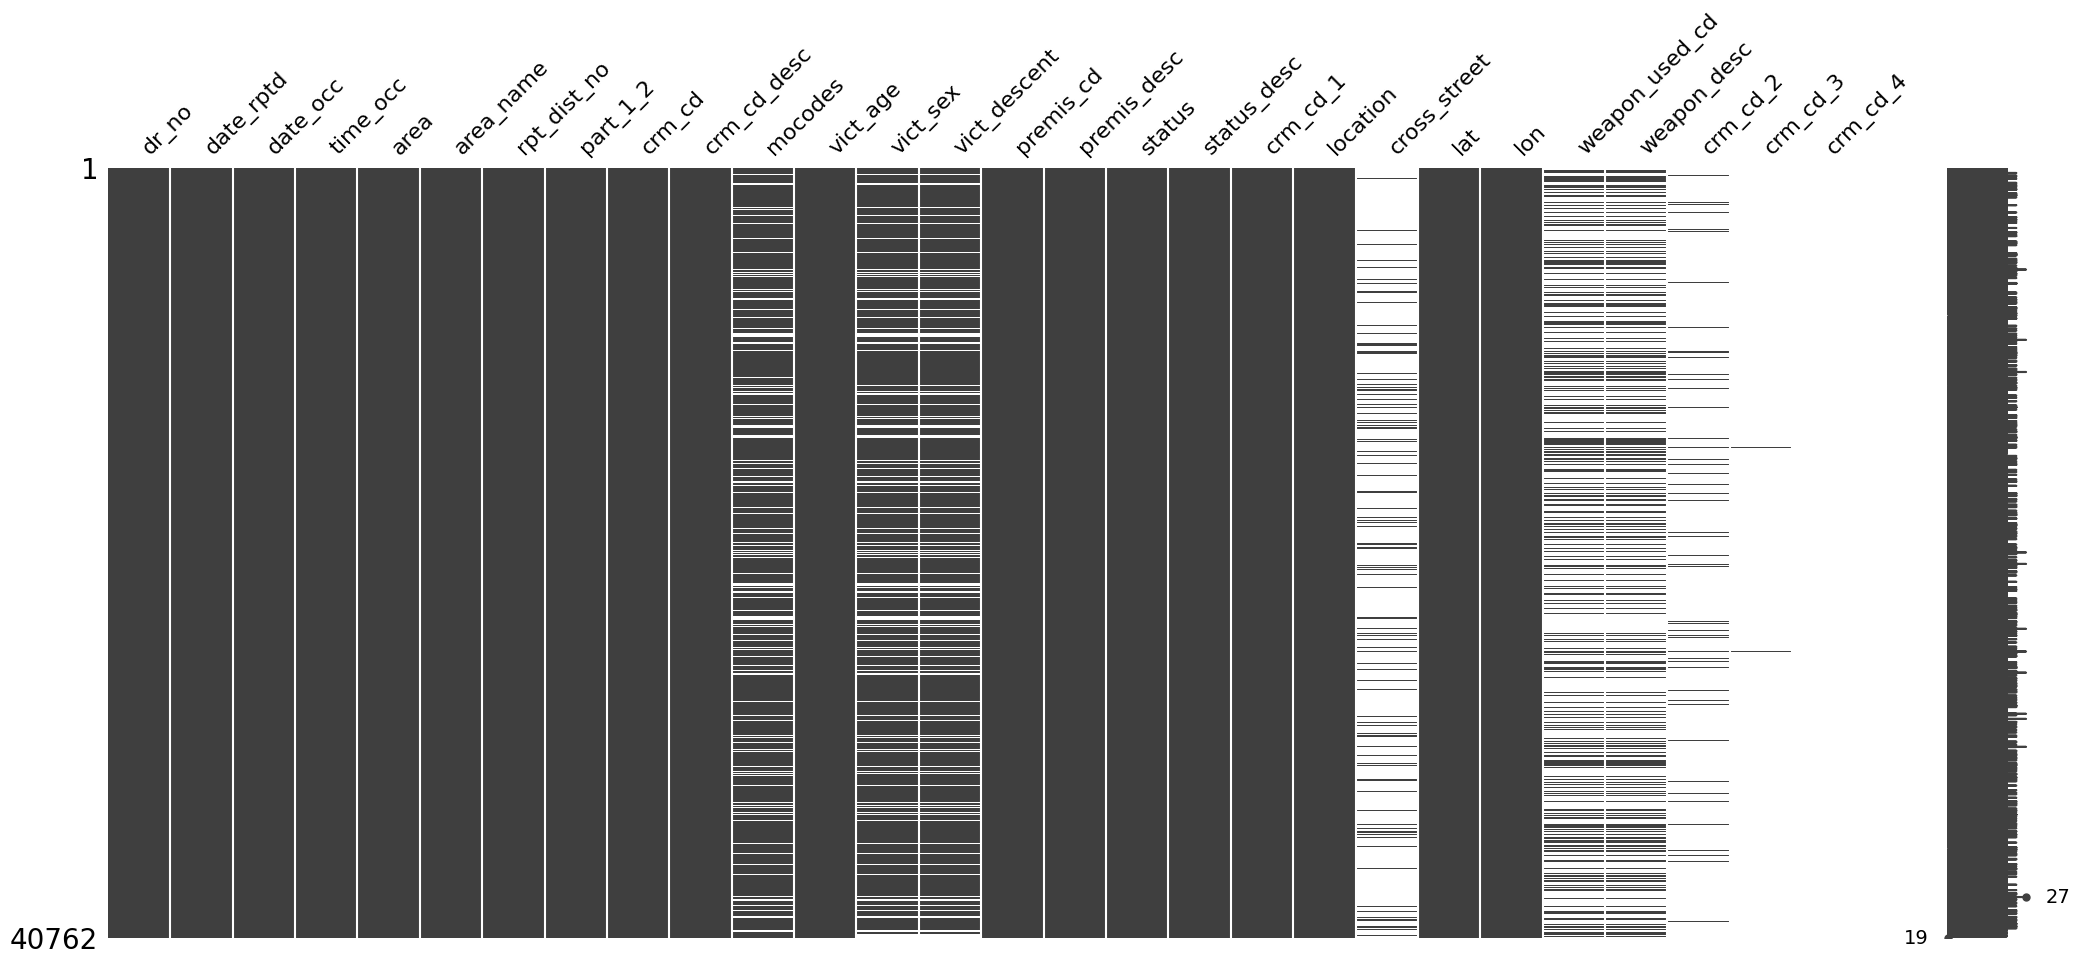

In [72]:
msno.matrix(data)

<Axes: >

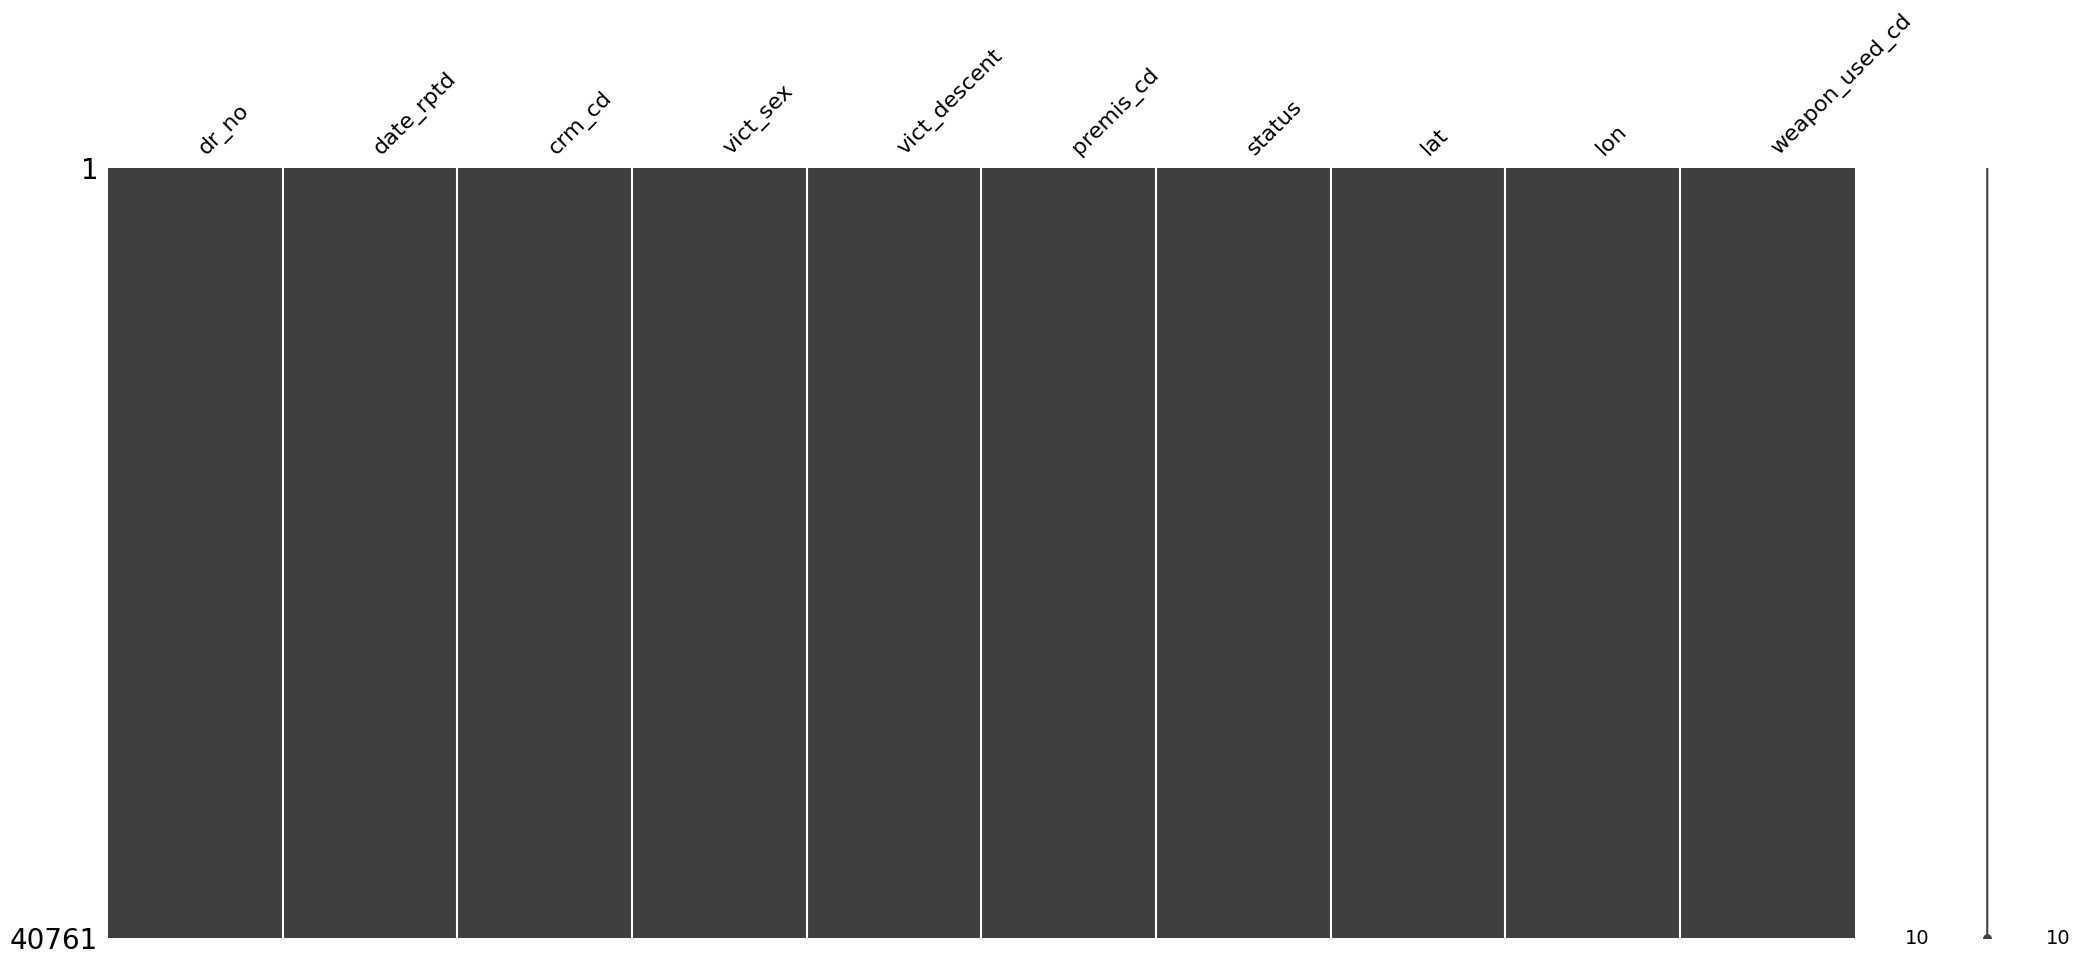

In [73]:
msno.matrix(cleaner.df)

### Clipping

In [74]:
cleaner.clipping()

array([[<Axes: title={'center': 'date_rptd'}>,
        <Axes: title={'center': 'date_occ'}>],
       [<Axes: title={'center': 'time_occ'}>,
        <Axes: title={'center': 'vict_age'}>],
       [<Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lon'}>]],
      dtype=object)

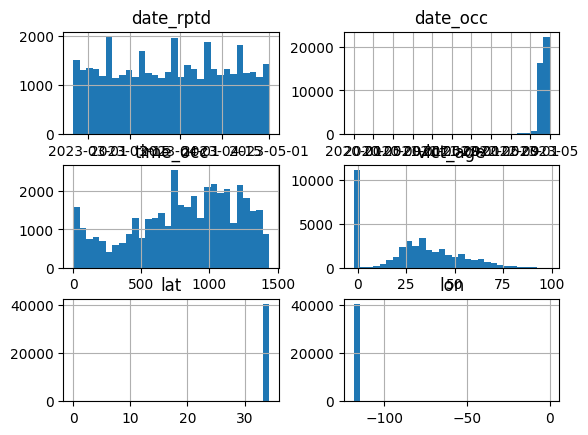

In [75]:
data.hist(bins=30)

array([[<Axes: title={'center': 'date_rptd'}>,
        <Axes: title={'center': 'lat'}>],
       [<Axes: title={'center': 'lon'}>, <Axes: >]], dtype=object)

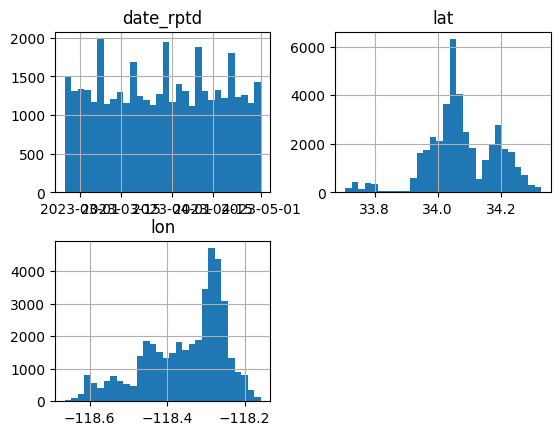

In [76]:
cleaner.df.hist(bins=30)

### Imputación

In [77]:
cleaner.simple_imp()

In [78]:
cleaner.df.isna().mean()

dr_no             0.0
date_rptd         0.0
crm_cd            0.0
vict_sex          0.0
vict_descent      0.0
premis_cd         0.0
status            0.0
lat               0.0
lon               0.0
weapon_used_cd    0.0
dtype: float64

### Lugar

In [79]:
cleaner.lugar()

<Axes: xlabel='premis_cd', ylabel='count'>

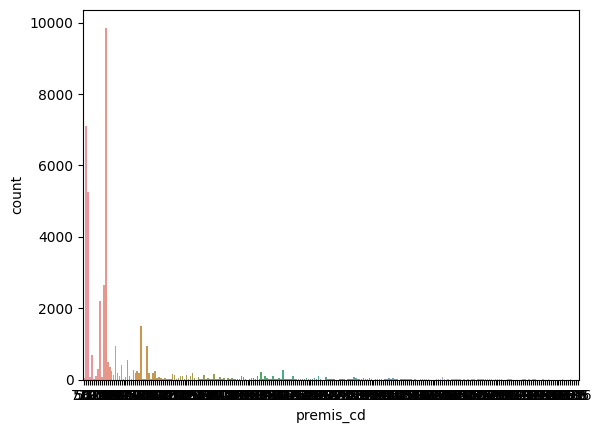

In [80]:
sns.countplot(data, x="premis_cd")

<module 'matplotlib.pyplot' from '/home/bluterplay/jupyter/vlapd/lib/python3.10/site-packages/matplotlib/pyplot.py'>

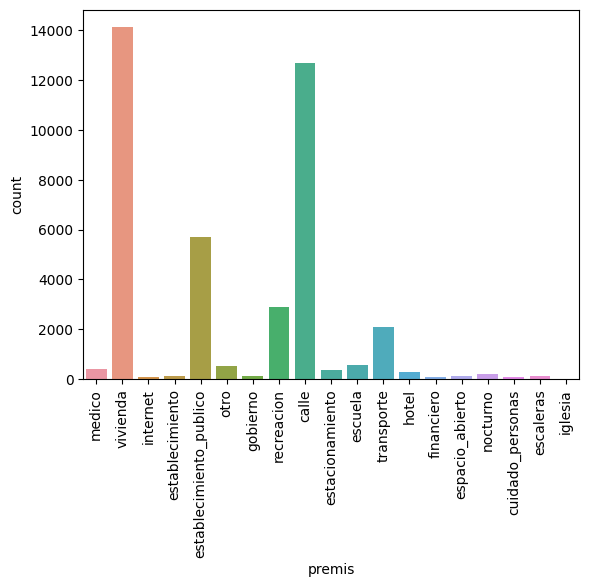

In [49]:
g=sns.countplot(cleaner.df,x="premis")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt

### Zonas

In [81]:
cleaner.zonas()

In [82]:
cleaner.df["zonas"].value_counts()/len(cleaner.df)

0    0.489316
1    0.176394
3    0.175143
2    0.116876
4    0.042271
Name: zonas, dtype: float64

### Categoricas

In [83]:
cleaner.categorias()

In [84]:
cleaner.df["premis"].value_counts()/len(cleaner.df)

vivienda                   0.346189
calle                      0.311155
establecimiento_publico    0.140109
Others                     0.079414
recreacion                 0.071441
transporte                 0.051692
Name: premis, dtype: float64

### Super clases

In [85]:
cleaner.super_clases()

In [86]:
cleaner.df.head()

,dr_no,date_rptd,vict_sex,vict_descent,premis_cd,status,lat,lon,weapon_used_cd,premis,zonas,crime,crm_cd
0,232006471,2023-02-24,F,O,719.0,IC,34.0628,-118.2917,0,Others,0,Robo,103
1,231208405,2023-02-24,F,B,501.0,IC,33.9618,-118.3025,0,vivienda,0,Falta a la ley,102
2,230606306,2023-02-24,F,W,501.0,IC,34.1162,-118.3738,0,vivienda,3,Falta a la ley,102
3,231605764,2023-02-24,M,H,502.0,IC,34.2166,-118.3919,0,vivienda,1,Falta a la ley,102
4,230906092,2023-02-24,M,W,501.0,IC,34.1649,-118.4225,0,vivienda,1,Robo,103


## Cubo

In [95]:
from datetime import datetime
from pandas import date_range, read_csv, DataFrame
from statsmodels.tsa.api import SimpleExpSmoothing

class CubeCrimesGenerator():
    
    def __init__(self,df):
        self.df = df.copy()
        data= self.df.copy()
        data["Date"]=data["date_rptd"]
        self.start= str(data["Date"].min())
        self.end= str(data["Date"].max())
        self.ls_dfs=[]
    
    def checkDates(self,data,zone,crimeType):
        data["Date"]=data["date_rptd"]
        date_index = date_range(start=self.start, end=self.end, freq="D")
        data = data.set_index("Date").reindex(date_index)
        data.drop(columns=["date_rptd"], inplace=True)
        field = "Crimes_Z"+str(zone)+"T"+str(crimeType)
        data.rename(columns={0: field}, inplace= True)
        data[field]= data[field].fillna(0)
        return data
    
    
    def generateDataframes(self):
        ls_dfs= []
        for zone in range(5):
            test = self.df[self.df['zonas']==zone].copy()
            for crime in range(100,105):
                test2 = test[test['crm_cd']==crime].copy()
                temp =test2.groupby('date_rptd').size().copy()
                temp= temp.to_frame()
                temp= temp.reset_index()
                data= self.checkDates(temp,zone,crime)
                self.ls_dfs.append(data)
                
    def generateCube(self):
        self.generateDataframes()
        df_final= self.ls_dfs[0]

        for i in range(1, len(self.ls_dfs)):
            column= self.ls_dfs[i].columns[0]
            df_final[column]= list(self.ls_dfs[i][column])
            
        return df_final

In [92]:
cubo= CubeCrimesGenerator(cleaner.df)

In [93]:
df_cubo=cubo.generateCube()

In [94]:
df_cubo

,Crimes_Z0T100,Crimes_Z0T101,Crimes_Z0T102,Crimes_Z0T103,Crimes_Z0T104,Crimes_Z1T100,Crimes_Z1T101,Crimes_Z1T102,Crimes_Z1T103,Crimes_Z1T104,...,Crimes_Z3T100,Crimes_Z3T101,Crimes_Z3T102,Crimes_Z3T103,Crimes_Z3T104,Crimes_Z4T100,Crimes_Z4T101,Crimes_Z4T102,Crimes_Z4T103,Crimes_Z4T104
2023-02-24,50,34,18,70,92,12,9,2.0,25,32,...,11,10,8,37,35,2,3.0,2.0,10.0,14
2023-02-25,54,37,9,62,81,8,3,1.0,7,19,...,11,2,3,24,28,8,2.0,1.0,3.0,4
2023-02-26,52,41,10,50,89,25,15,13.0,27,47,...,14,8,5,33,34,9,4.0,1.0,2.0,12
2023-02-27,59,44,19,99,118,19,13,17.0,31,42,...,25,25,11,31,41,5,3.0,2.0,6.0,13
2023-02-28,75,40,19,61,87,28,20,11.0,25,36,...,8,15,11,40,41,17,6.0,3.0,4.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-27,74,60,20,71,110,27,11,9.0,18,34,...,11,8,6,28,28,4,1.0,0.0,2.0,10
2023-04-28,52,34,16,58,106,21,9,8.0,33,38,...,13,20,6,34,31,7,3.0,1.0,7.0,11
2023-04-29,73,45,11,55,94,20,17,2.0,30,31,...,25,9,5,28,28,3,3.0,1.0,3.0,6
2023-04-30,69,41,7,54,75,21,9,3.0,11,22,...,19,15,1,24,23,7,3.0,1.0,2.0,8


## Feature engineering

In [147]:
class FeatureEngineering():
    
    def __init__(self,df):
        self.df= df
        self.temp= DataFrame()
        
    def createLags(self,column):
        temp= self.df[[column]]
        for i in range(1,34):
            temp[column+"_"+str(i)] = temp[column].shift(i)
        self.temp=temp
    
    def smoothing(self, column):
        for i in range(2,10,1):
            j=i/10
            fit1 = SimpleExpSmoothing(self.temp[column], initialization_method="heuristic").fit(smoothing_level=j, optimized=False)
            lista=fit1.fittedvalues
            self.temp['exp'+str(j)]=lista
            
    def createMA(self,column):
        for i in range(10,50,10):
            self.temp["MA"+str(i)]= self.temp[column].rolling(window =i).mean()
    
    def scalerData(self,column,sc,sc2):
        X,y=self.temp.drop([column],axis=1).to_numpy(),self.temp[[column]].to_numpy(),

        X=sc.transform(X)
        y=sc2.transform(y)


        X= X.reshape(X.shape[0], 1, X.shape[1])
        return X, y
    
    def createVariables(self,column):
        self.createLags(column)
        self.smoothing(column)
        self.createMA(column)
        self.temp.dropna(inplace=True)
        zone=colummn[8]
        crime=colummn[10:]
        scx_file="models/FeatureEngineer/Scalers/sc_x_"+crime+"_"+zone+".pkl"
        scy_file="models/FeatureEngineer/Scalers/sc_y_"+crime+"_"+zone+".pkl"
        with open(scx_file, "rb") as fp:
            sc= pickle.load(fp)
        with open(scy_file, "rb") as fp:
            sc2= pickle.load(fp)
        return self.scalerData(colummn,sc,sc2)

### Create lags

In [133]:
feature= FeatureEngineering(df_cubo)

In [134]:
column="Crimes_Z0T100"

In [135]:
feature.createLags(column)

In [136]:
feature.temp.head()

,Crimes_Z0T100,Crimes_Z0T100_1,Crimes_Z0T100_2,Crimes_Z0T100_3,Crimes_Z0T100_4,Crimes_Z0T100_5,Crimes_Z0T100_6,Crimes_Z0T100_7,Crimes_Z0T100_8,Crimes_Z0T100_9,...,Crimes_Z0T100_24,Crimes_Z0T100_25,Crimes_Z0T100_26,Crimes_Z0T100_27,Crimes_Z0T100_28,Crimes_Z0T100_29,Crimes_Z0T100_30,Crimes_Z0T100_31,Crimes_Z0T100_32,Crimes_Z0T100_33
2023-02-24,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-25,54,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-26,52,54.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-27,59,52.0,54.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28,75,59.0,52.0,54.0,50.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Smothing

In [137]:
feature.smoothing(column)

In [138]:
feature.temp.head()

,Crimes_Z0T100,Crimes_Z0T100_1,Crimes_Z0T100_2,Crimes_Z0T100_3,Crimes_Z0T100_4,Crimes_Z0T100_5,Crimes_Z0T100_6,Crimes_Z0T100_7,Crimes_Z0T100_8,Crimes_Z0T100_9,...,Crimes_Z0T100_32,Crimes_Z0T100_33,exp0.2,exp0.3,exp0.4,exp0.5,exp0.6,exp0.7,exp0.8,exp0.9
2023-02-24,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,52.733333,52.733333,52.733333,52.733333,52.733333,52.733333,52.733333,52.733333
2023-02-25,54,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,52.186667,51.913333,51.640000,51.366667,51.093333,50.820000,50.546667,50.273333
2023-02-26,52,54.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,52.549333,52.539333,52.584000,52.683333,52.837333,53.046000,53.309333,53.627333
2023-02-27,59,52.0,54.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,52.439467,52.377533,52.350400,52.341667,52.334933,52.313800,52.261867,52.162733
2023-02-28,75,59.0,52.0,54.0,50.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,53.751573,54.364273,55.010240,55.670833,56.333973,56.994140,57.652373,58.316273


### Create MA

In [139]:
feature.createMA(column)

In [140]:
feature.temp.tail()

,Crimes_Z0T100,Crimes_Z0T100_1,Crimes_Z0T100_2,Crimes_Z0T100_3,Crimes_Z0T100_4,Crimes_Z0T100_5,Crimes_Z0T100_6,Crimes_Z0T100_7,Crimes_Z0T100_8,Crimes_Z0T100_9,...,exp0.4,exp0.5,exp0.6,exp0.7,exp0.8,exp0.9,MA10,MA20,MA30,MA40
2023-04-27,74,57.0,73.0,68.0,75.0,71.0,82.0,64.0,53.0,68.0,...,65.742892,64.406305,62.975498,61.518699,60.051863,58.556691,68.5,68.80,66.433333,65.725
2023-04-28,52,74.0,57.0,73.0,68.0,75.0,71.0,82.0,64.0,53.0,...,69.045735,69.203153,69.590199,70.255610,71.210373,72.455669,66.9,67.85,66.100000,65.375
2023-04-29,73,52.0,74.0,57.0,73.0,68.0,75.0,71.0,82.0,64.0,...,62.227441,60.601576,59.036080,57.476683,55.842075,54.045567,68.9,68.40,66.466667,65.325
2023-04-30,69,73.0,52.0,74.0,57.0,73.0,68.0,75.0,71.0,82.0,...,66.536465,66.800788,67.414432,68.343005,69.568415,71.104557,69.4,67.95,66.633333,65.575
2023-05-01,40,69.0,73.0,52.0,74.0,57.0,73.0,68.0,75.0,71.0,...,67.521879,67.900394,68.365773,68.802901,69.113683,69.210456,65.2,66.40,65.933333,65.500


In [141]:
feature.temp.dropna(inplace=True)

In [142]:
feature.temp.head()

,Crimes_Z0T100,Crimes_Z0T100_1,Crimes_Z0T100_2,Crimes_Z0T100_3,Crimes_Z0T100_4,Crimes_Z0T100_5,Crimes_Z0T100_6,Crimes_Z0T100_7,Crimes_Z0T100_8,Crimes_Z0T100_9,...,exp0.4,exp0.5,exp0.6,exp0.7,exp0.8,exp0.9,MA10,MA20,MA30,MA40
2023-04-04,61,75.0,55.0,61.0,64.0,62.0,62.0,65.0,65.0,72.0,...,65.695517,66.802463,68.114738,69.607224,71.261004,73.062803,64.2,63.65,64.966667,63.475
2023-04-05,69,61.0,75.0,55.0,61.0,64.0,62.0,62.0,65.0,65.0,...,63.817310,63.901232,63.845895,63.582167,63.052201,62.206280,63.9,63.40,64.733333,63.950
2023-04-06,51,69.0,61.0,75.0,55.0,61.0,64.0,62.0,62.0,65.0,...,65.890386,66.450616,66.938358,67.374650,67.810440,68.320628,62.5,63.40,64.433333,63.875
2023-04-07,57,51.0,69.0,61.0,75.0,55.0,61.0,64.0,62.0,62.0,...,59.934232,58.725308,57.375343,55.912395,54.362088,52.732063,61.7,62.65,63.900000,64.000
2023-04-08,71,57.0,51.0,69.0,61.0,75.0,55.0,61.0,64.0,62.0,...,58.760539,57.862654,57.150137,56.673719,56.472418,56.573206,62.6,62.90,63.900000,64.300


### Scaler

In [143]:
zone=colummn[8]
crime=colummn[10:]
scx_file="models/FeatureEngineer/Scalers/sc_x_"+crime+"_"+zone+".pkl"
scy_file="models/FeatureEngineer/Scalers/sc_y_"+crime+"_"+zone+".pkl"

In [144]:
with open(scx_file, "rb") as fp:
    sc= pickle.load(fp)
with open(scy_file, "rb") as fp:
    sc2= pickle.load(fp)

In [146]:
X,y=feature.scalerData(colummn,sc,sc2)